In [1]:
from IPython.display import Image

In [2]:
import torch

## 0. What are we doing and why?

In general, we are building a map from sensors on an autopiloted car. In detail, we are making a plugin to integrate it with existing approaches to improve them. The idea of the plugin is to store the maps we have already built, organized in one global map, to use them as a prior for building new local maps.

This is not the first architecture to use history as a prior. Another one is NMP, here it is (sect. 3 of https://arxiv.org/pdf/2304.08481)


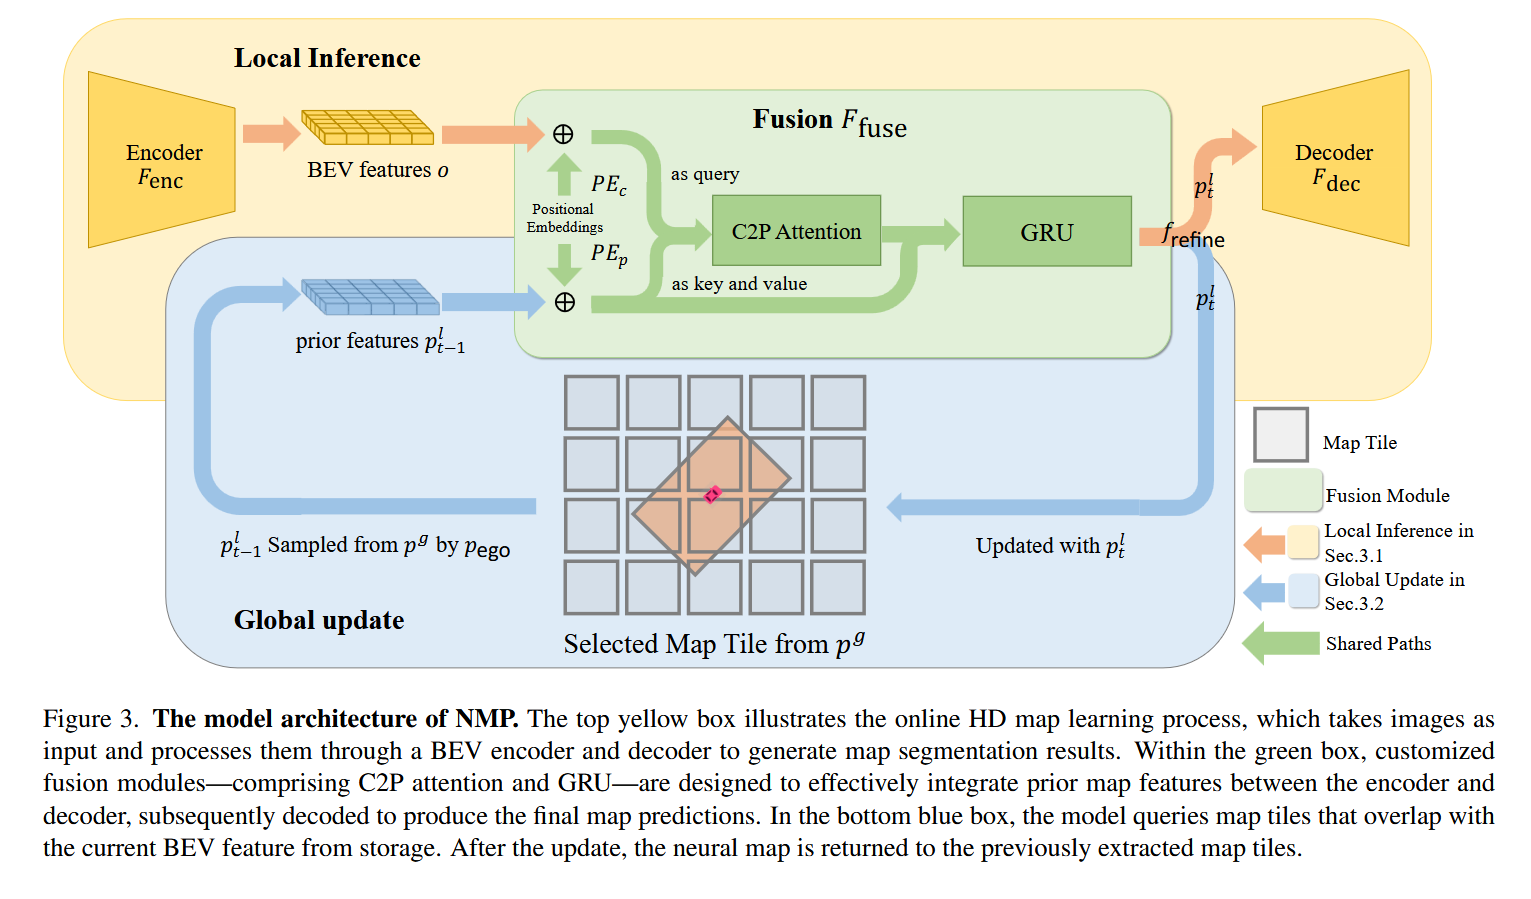

In [ ]:
display(Image("reportFigs/nmp.png"))

Unlike HRMapNet, NMP keeps history of BEV (bird's-eye view) features. HRMapNet's authors claim that their approach is much more efficient in memory:
> Take the Boston map in nuScenes dataset [1] as
an example, BEV features require over 11 GB memory in NMP [45]. By contrast,
we propose to maintain a low-cost historical rasterized map for vectorized map
perception, which takes only 120 MB memory for the same Boston map.

### Why fight for memory?



 If we store the maps on an external server, then there is no need.
There are upsides in maintaing a server with a global map:
1. If we have several cars self-driving around the city, their important updates to the global map
(like collisions, roadworks, traffic jams, etc.) will be uploaded to the server
and thus accessed by other cars;
2. inference can be carried out completely externally,
instead of installing GPUs in cars and infering "on the go".
This is important since GPUs might fail. 
If there is a GPU fault on the server, 
inference just switches to another unit,
while a fault on an internal GPU in a self-driving car 
sounds like a very dangerous occasion.

But the downsides are obvious: the connection is both a bottleneck and the main risk.
The risk of a faulty connection, however, can be mitigated by having an offline 
"backup" GPU installed in a vehicle.

Anyway, although using a server is an idea worth discussion, it is out of scope for the current paper.
HRMapNet is a tool for efficient local map generation without any external help 
(unlike the NMP paper, which seems pretty enthusiastic about uploading the map.) 

Also, freeing up memory allows us to add new, perhaps costly, mechanisms to the net 
(I will propose one at the end :).)

The memory difference is expected since raster maps are (perhaps, sparse) tensors of shape $N\times H \times W $ 
(where $N$ is a number of classes, i.e. 3 in all the examples: lane divider, road boundary and pedestrian crossing), 
whereas BEV feature maps are (likely non-sparse) tensors of shape $Ch \times H \times W$,
where $Ch$ equals 256 in the experiments NMP authors run
(BTW, $\frac {256} 3 \times 120 MB \approx 11GB$, so this simple intuition adds up.)

### Why rasterize? 

As I've said, HRMapNet is a plugin that uses other nets. To predict new parts of the map it uses MapTR, a predictor of *vector* maps. So, why not keep a global map as a vector one, too?

I didn't find a definitive answer in the paper. Let's see what would architectually change 
if maps were left **un**-rasterized:
1. Updating the global vector map would be pretty clumsy,
since MapTR keeps shapes as arrays of $N_v$ points,
where $N_v$ is some global constant,
big enough to properly encode any shape in a *local* map.
Thus, we have a problem with maintaining global objects that do not fit in a single
local map tile --- for example, a very long lane divider on a highway.
Getting a local map seems very clumsy, too.
2. Using a vector local map in cross-attention is not a problem: we embed only vertices and initialize queries with them (since attn is quadratic in number of keys, this might even speed up this unit);
3. The map encoder and aggregation units, however, need a map to be an $N\times H \times W$ tensor 
(where extracted features are of shape $... \times H \times W$) to keep their simple convolutional architecture.
I suppose, if we wanted to keep the global map as a vector map, these two units would have needed to rasterize it anyway. I suppose, the authors had no reason to perform rasterization on every step and decided not to
bother and pass a rasterized map to every unit.

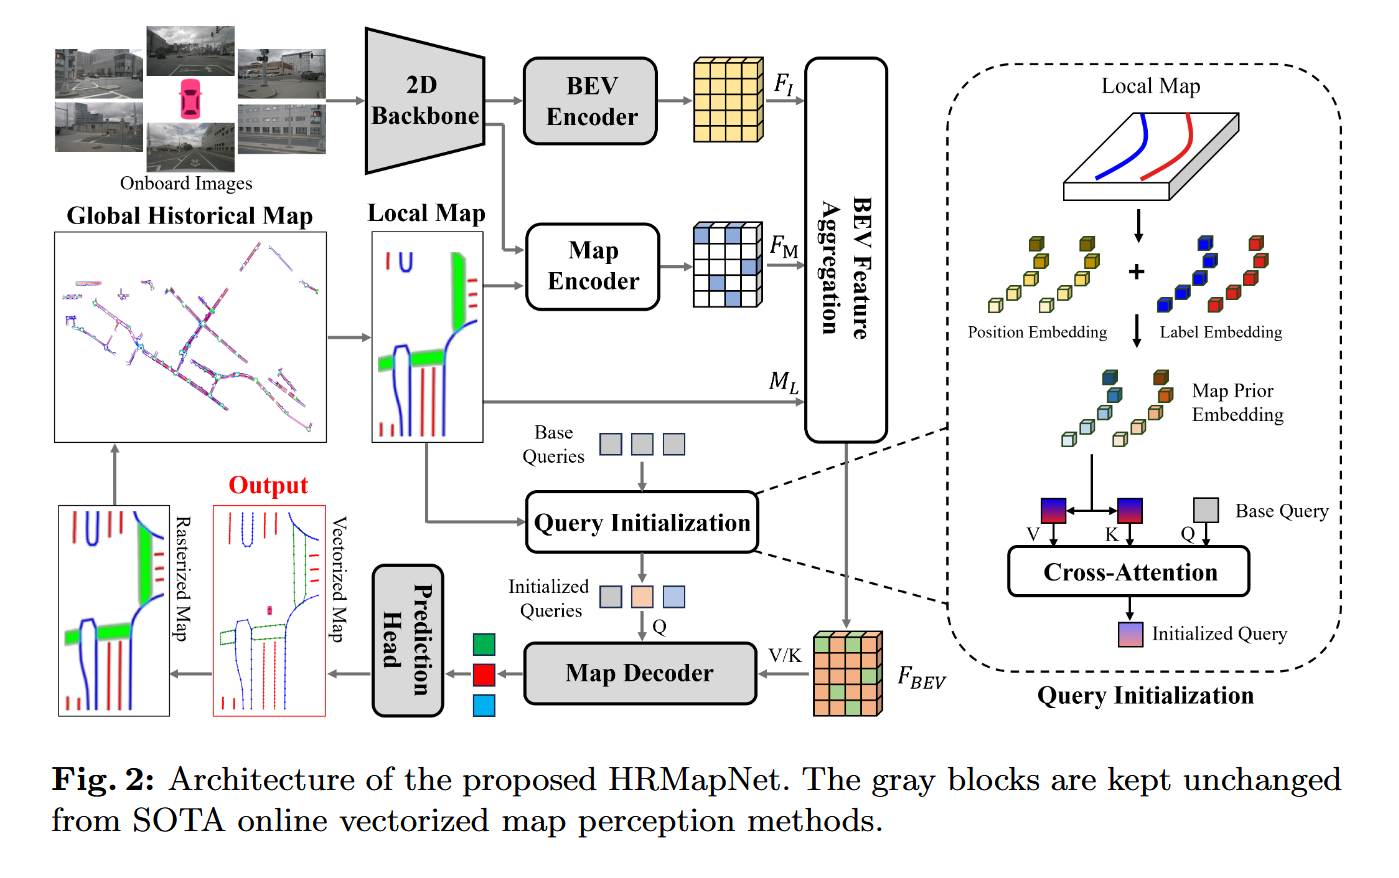

In [ ]:
display(Image('reportFigs/fig2_clean.png'))

I suppose, all these minor inconveniences advocate for rasterization quite well. 

Also, I can't think of any scaling issues raster images might run into when the net starts keeping bigger global maps (since the rasterized map is sparse). 
Moreover, raster images can be easily obtained from plenty of formats, unlike vector images.
This means that raster global maps are easier to precompute using "open-source" maps, which may be of various formats.

Finally, a rasterized map does not yield any "ambiguity" which MapTR authors are fighting with permutations, which is comforting to know, since this ambiguity seems rather hurtful (sect. 4.2 from https://arxiv.org/pdf/2208.14437).

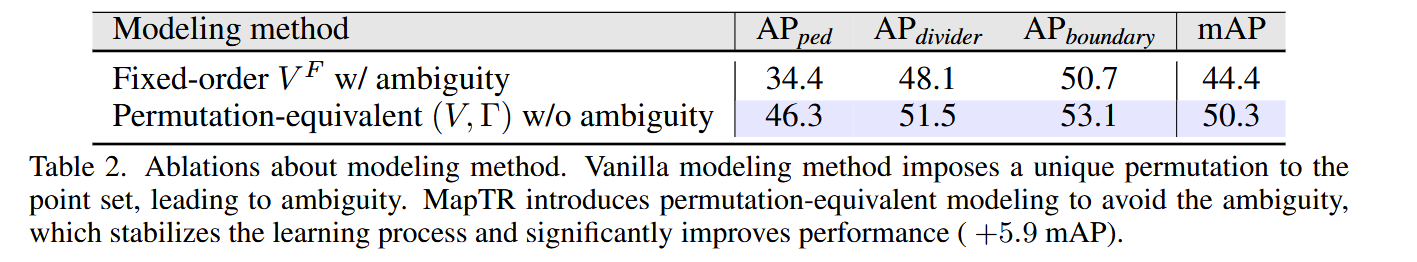

In [ ]:
display(Image("reportFigs/permut.png"))

### Let's take a step back...
and ask ourselves again, what are we doing.

How does retrieving a global map from sensors help automated vehicles? For example, if a self-driving car is going somewhere, it should have some sort of a map already, how else would it know where it is headed?

So, I suppose the use-case of this net in self-driving cars is the following: the car has an offline global map with lane separators, pedestrian crossings, etc. marked in it. This offline map directs the car and at the same time gives prior information to the net, which builds a more elaborate map, adding details absent in the offline map, like roadwoark, collisions and, of course, pedestrians; and also has a more accurate position of the vehicle. 

A much more direct application this technology would have for robots,
 for example, solving mazes or sprinting or doing any other activity that has a very clear direction without any sort of prior map.

## 1. Experiments


### Installation

I installed hrmapnet into a docker container. 
You will find the dockerfile at the end of this section. 
The steps a-e of the installation guide (https://github.com/HXMap/HRMapNet/blob/master/docs/install.md)
are already done during building the container



Then I ran container in interactive mode and followed the rest of the steps. 
At step g I ran
```bash
cd /path/to/HRMapNet/mmdetection3d
python -m pip install --no-cache-dir -e .
```

instead of the proposed

```bash
cd /path/to/HRMapNet/mmdetection3d
python setup.py develop
```



Actually, the latter is just 

```bash
pip install -e .
```

according to the comment in line 152 in `mmdetection3d\setup.py`.
Just as my experience in development suggests,
the cache is both a blessing and a curse.


Than I had to fix some conflicts in versions. Here are the amendments
1. Downgrade `av2` to minimum,
2. Downgare `numpy` to 1.23.0,
3. Install `gcc-multilib`,
4. Upgrade `gcc` to 7 (https://anaconda.org/gouarin/gcc-7).

After those steps, the visualisation script finally started running.

###### dockerfile

```dockerfile
ARG CUDA_VERSION=11.3.1
ARG OS_VERSION=20.04
# pull a prebuilt image
FROM nvidia/cuda:${CUDA_VERSION}-cudnn8-devel-ubuntu${OS_VERSION}

# setup timezone
ENV TZ=US/Pacific
RUN ln -snf /usr/share/zoneinfo/$TZ /etc/localtime && echo $TZ > /etc/timezone

SHELL ["/bin/bash", "-c"]

# Required to build Ubuntu 20.04 without user prompts with DLFW container
ENV DEBIAN_FRONTEND=noninteractive

# Install requried libraries
RUN apt-get update && apt-get install -y software-properties-common
RUN add-apt-repository ppa:ubuntu-toolchain-r/test
RUN apt-get update && apt-get install -y --no-install-recommends \
    libcurl4-openssl-dev \
    wget \
    zlib1g-dev \
    git \
    sudo \
    ssh \
    libssl-dev \
    pbzip2 \
    pv \
    bzip2 \
    unzip \
    devscripts \
    lintian \
    fakeroot \
    dh-make \
    build-essential \
    curl \
    ca-certificates \
    libx11-6 \
    nano \
    graphviz \
    libgl1-mesa-glx \
    openssh-server \
    apt-transport-https

# Install other dependencies
RUN apt-get update && apt-get install -y --no-install-recommends \
    libgtk2.0-0 \
    libcanberra-gtk-module \
    libsm6 libxext6 libxrender-dev \
    libgtk2.0-dev pkg-config \
    libopenmpi-dev \
 && sudo rm -rf /var/lib/apt/lists/*

# Install Miniconda
RUN wget \
    https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
    && mkdir /root/.conda \
    && bash Miniconda3-latest-Linux-x86_64.sh -b \
    && rm -f Miniconda3-latest-Linux-x86_64.sh 

ENV CONDA_DEFAULT_ENV=${project}
ENV CONDA_PREFIX=/root/miniconda3/envs/$CONDA_DEFAULT_ENV
ENV PATH=/root/miniconda3/bin:$CONDA_PREFIX/bin:$PATH

# install python 3.8
RUN conda install python=3.8
RUN alias python='/root/miniconda3/envs/bin/python3.8'

# Set environment and working directory
ENV CUDA_HOME=/usr/local/cuda
ENV LD_LIBRARY_PATH=$CUDA_HOME/lib64:$CUDA_HOME/extras/CUPTI/lib64/:$LD_LIBRARY_PATH
ENV PATH=$CUDA_HOME/bin:$PATH
ENV CFLAGS="-I$CUDA_HOME/include $CFLAGS"
ENV FORCE_CUDA="1"
ENV PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/miniconda3/envs/bin:$PATH

# install pytorch
RUN pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

# install opencv
RUN python -m pip install opencv-python==4.5.5.62

# install gcc
RUN conda install -c omgarcia gcc-6

# install torchpack
RUN git clone https://github.com/zhijian-liu/torchpack.git
RUN cd torchpack && python -m pip install -e .

# install mmdetection3d from source
ENV TORCH_CUDA_ARCH_LIST="7.0+PTX"
ENV TORCH_NVCC_FLAGS="-Xfatbin -compress-all"
ENV CMAKE_PREFIX_PATH="$(dirname $(which conda))/../"

# install other dependencies
RUN python -m pip install mmcv-full==1.4.0 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
RUN python -m pip install pillow==8.4.0 \
                          tqdm \
                          mmdet==2.14.0 \
                          mmsegmentation==0.14.1 \
                          numba \
                          mpi4py \
                          nuscenes-devkit \
                          setuptools==59.5.0

RUN apt-get update && apt-get install -y ffmpeg libsm6 libxext6 git ninja-build libglib2.0-0 libsm6 libxrender-dev libxext6 \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*

# libraries path
RUN ln -s /usr/local/cuda/lib64/libcusolver.so.11 /usr/local/cuda/lib64/libcusolver.so.10

# install timm
RUN python -m pip install timm
RUN pip install yapf==0.40.1

RUN ["/bin/bash"]
ARG CUDA_VERSION=11.3.1
ARG OS_VERSION=20.04
# pull a prebuilt image
FROM nvidia/cuda:${CUDA_VERSION}-cudnn8-devel-ubuntu${OS_VERSION}

# setup timezone
ENV TZ=US/Pacific
RUN ln -snf /usr/share/zoneinfo/$TZ /etc/localtime && echo $TZ > /etc/timezone

SHELL ["/bin/bash", "-c"]

# Required to build Ubuntu 20.04 without user prompts with DLFW container
ENV DEBIAN_FRONTEND=noninteractive

# Install requried libraries
RUN apt-get update && apt-get install -y software-properties-common
RUN add-apt-repository ppa:ubuntu-toolchain-r/test
RUN apt-get update && apt-get install -y --no-install-recommends \
    libcurl4-openssl-dev \
    wget \
    zlib1g-dev \
    git \
    sudo \
    ssh \
    libssl-dev \
    pbzip2 \
    pv \
    bzip2 \
    unzip \
    devscripts \
    lintian \
    fakeroot \
    dh-make \
    build-essential \
    curl \
    ca-certificates \
    libx11-6 \
    nano \
    graphviz \
    libgl1-mesa-glx \
    openssh-server \
    apt-transport-https

# Install other dependencies
RUN apt-get update && apt-get install -y --no-install-recommends \
    libgtk2.0-0 \
    libcanberra-gtk-module \
    libsm6 libxext6 libxrender-dev \
    libgtk2.0-dev pkg-config \
    libopenmpi-dev \
 && sudo rm -rf /var/lib/apt/lists/*

# Install Miniconda
RUN wget \
    https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
    && mkdir /root/.conda \
    && bash Miniconda3-latest-Linux-x86_64.sh -b \
    && rm -f Miniconda3-latest-Linux-x86_64.sh 

ENV CONDA_DEFAULT_ENV=${project}
ENV CONDA_PREFIX=/root/miniconda3/envs/$CONDA_DEFAULT_ENV
ENV PATH=/root/miniconda3/bin:$CONDA_PREFIX/bin:$PATH

# install python 3.8
RUN conda install python=3.8
RUN alias python='/root/miniconda3/envs/bin/python3.8'

# Set environment and working directory
ENV CUDA_HOME=/usr/local/cuda
ENV LD_LIBRARY_PATH=$CUDA_HOME/lib64:$CUDA_HOME/extras/CUPTI/lib64/:$LD_LIBRARY_PATH
ENV PATH=$CUDA_HOME/bin:$PATH
ENV CFLAGS="-I$CUDA_HOME/include $CFLAGS"
ENV FORCE_CUDA="1"
ENV PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/miniconda3/envs/bin:$PATH

# install pytorch
RUN pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

# install opencv
RUN python -m pip install opencv-python==4.5.5.62

# install gcc
RUN conda install -c omgarcia gcc-6

# install torchpack
RUN git clone https://github.com/zhijian-liu/torchpack.git
RUN cd torchpack && python -m pip install -e .

# install mmdetection3d from source
ENV TORCH_CUDA_ARCH_LIST="7.0+PTX"
ENV TORCH_NVCC_FLAGS="-Xfatbin -compress-all"
ENV CMAKE_PREFIX_PATH="$(dirname $(which conda))/../"

# install other dependencies
RUN python -m pip install mmcv-full==1.4.0 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
RUN python -m pip install pillow==8.4.0 \
                          tqdm \
                          mmdet==2.14.0 \
                          mmsegmentation==0.14.1 \
                          numba \
                          mpi4py \
                          nuscenes-devkit \
                          setuptools==59.5.0

RUN apt-get update && apt-get install -y ffmpeg libsm6 libxext6 git ninja-build libglib2.0-0 libsm6 libxrender-dev libxext6 \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*

# libraries path
RUN ln -s /usr/local/cuda/lib64/libcusolver.so.11 /usr/local/cuda/lib64/libcusolver.so.10

# install timm
RUN python -m pip install timm
RUN pip install yapf==0.40.1

RUN ["/bin/bash"]
```

### Preparing Data

Data preparation is described in https://github.com/HXMap/HRMapNet/blob/master/docs/prepare_dataset.md.
To make it work, I had to
1. Upgrade `networkx` to 3.1 (https://github.com/hustvl/MapTR/issues/189#issuecomment-2357921802)

#### Using mini 

I decided to use the mini version of the dataset, since the actual splits are too big.
To do it, you should 
1. Download the mini version from the same site (https://www.nuscenes.org/download),
2. Download the CAN bus extension (same link),
3. Download the Map expansion pack (v1.3) (same link),
2. Copy all of this to the container and unpack it there into `data` folder (see the folder structure below),
3. Move map extensions to `data/nuscenes/maps`
4. Create two copies of `v1.0-mini`: `v1.0-trainval` and `v1.0-test`.


After that, proceed with the guide, generating annotation files.

For some reason, I had to create a folder `data/nuscenes/maptrv2_pkl` and copy (not move!) annotation files there.


The resulting folder structure should be:
```python
HRMapNet
├── data/
│   ├── can_bus/
│   ├── nuscenes/
│   │   ├── maps/
│   │   │   ├── basemap/
│   │   │   ├── expansion/
│   │   │   ├── prediction/
│   │   ├── samples/
│   │   ├── sweeps/
│   │   ├── v1.0-test/
|   |   ├── v1.0-trainval/
│   │   ├── maptrv2_pkl/
├── ...
```


#### Running...
... out of memory (or not)

Once I run visualization, docker stats go crazy (especially CPU, I got 190% pretty frequently)

```bash
$ docker stats --no-stream
CONTAINER ID   NAME               CPU %     MEM USAGE / LIMIT     MEM %     NET I/O       BLOCK I/O   PIDS
cc1066adccf4   stupefied_panini   112.99%   1.415GiB / 7.698GiB   18.38%    1.88kB / 0B   0B / 0B     20
$ docker stats --no-stream
CONTAINER ID   NAME               CPU %     MEM USAGE / LIMIT     MEM %     NET I/O       BLOCK I/O   PIDS
cc1066adccf4   stupefied_panini   62.70%    2.448GiB / 7.698GiB   31.80%    1.88kB / 0B   0B / 0B     22
$ docker stats --no-stream
CONTAINER ID   NAME               CPU %     MEM USAGE / LIMIT     MEM %     NET I/O       BLOCK I/O   PIDS
cc1066adccf4   stupefied_panini   61.67%    3.701GiB / 7.698GiB   48.08%    1.88kB / 0B   0B / 0B     22
$ docker stats --no-stream
CONTAINER ID   NAME               CPU %     MEM USAGE / LIMIT     MEM %     NET I/O       BLOCK I/O   PIDS
cc1066adccf4   stupefied_panini   70.58%    4.793GiB / 7.698GiB   62.26%    1.88kB / 0B   0B / 0B     22
```

(and then it crashes)

```python
Traceback (most recent call last):
  File "./tools/test.py", line 264, in <module>
    main()
  File "./tools/test.py", line 229, in main
    model = MMDistributedDataParallel(
  File "/root/miniconda3/envs/smth/lib/python3.8/site-packages/torch/nn/parallel/distributed.py", line 496, in __init__
    dist._verify_model_across_ranks(self.process_group, parameters)
RuntimeError: NCCL error in: ../torch/lib/c10d/ProcessGroupNCCL.cpp:911, unhandled system error, NCCL version 2.7.8
ncclSystemError: System call (socket, malloc, munmap, etc) failed.
```

And I end up with an empty canvas

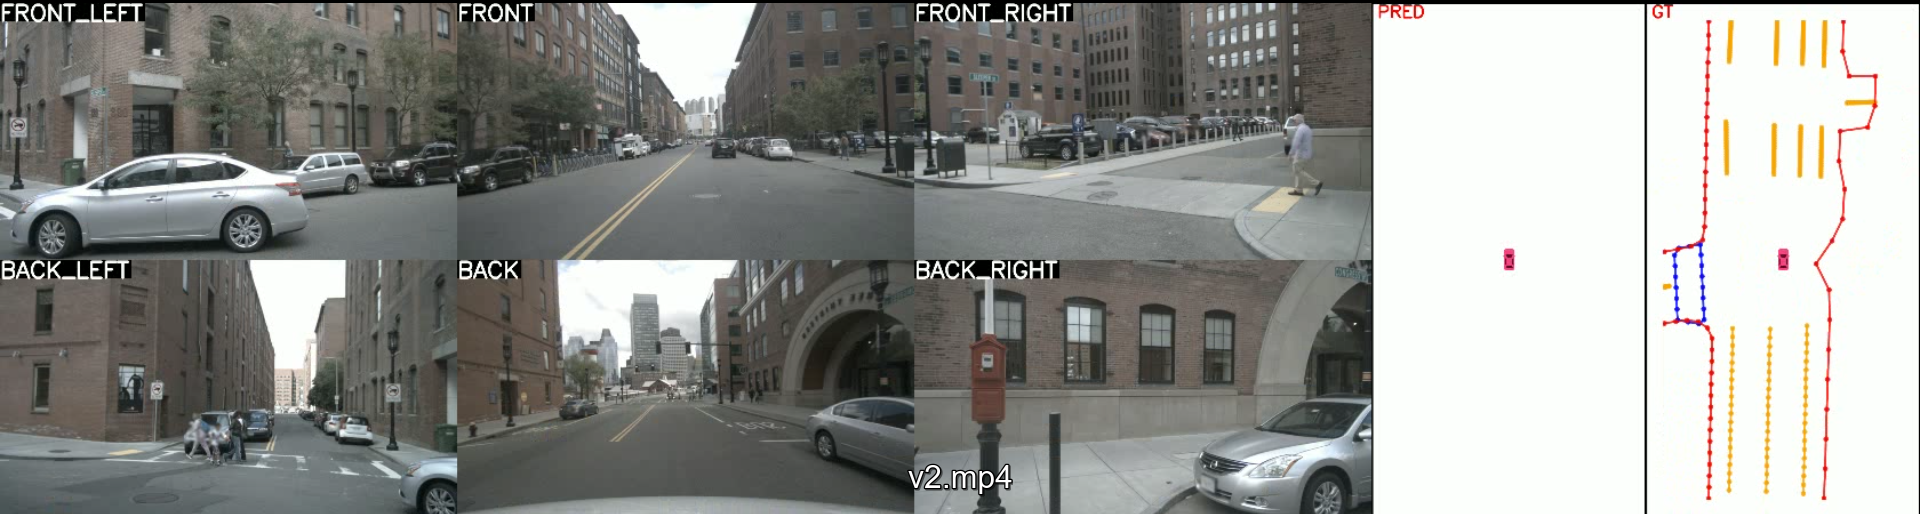

In [2]:
display(Image('reportFigs/mini-inference.png'))

Since this occured at model verification, I boldly decided to turn verification off, 
but the thing crashed again after consuming lots of resoucres, again.
```python
  File "./tools/test.py", line 229, in main
    model = MMDistributedDataParallel(
  File "/root/miniconda3/envs/smth/lib/python3.8/site-packages/torch/nn/parallel/distributed.py", line 498, in __init__
    self._sync_params_and_buffers(authoritative_rank=0)
  File "/root/miniconda3/envs/smth/lib/python3.8/site-packages/torch/nn/parallel/distributed.py", line 514, in _sync_params_and_buffers
    self._distributed_broadcast_coalesced(
  File "/root/miniconda3/envs/smth/lib/python3.8/site-packages/torch/nn/parallel/distributed.py", line 1278, in _distributed_broadcast_coalesced
    dist._broadcast_coalesced(
RuntimeError: NCCL error in: ../torch/lib/c10d/ProcessGroupNCCL.cpp:911, unhandled system error, NCCL version 2.7.8
ncclSystemError: System call (socket, malloc, munmap, etc) failed.
```

My initial guess was lack of resources. I debugged NCCL to verify it (with env variable `NCCL_DEBUG=WARN`), and it revealed the following:

```bash
cc1066adccf4:1794:1841 [0] graph/xml.cc:332 NCCL WARN Could not find real path of /sys/class/pci_bus/0000:01/../../0000:01:00.0
```

I'm not sure what it means, but it turns out to be a known issue with my environment (WSL) and version of NCCL (2.7.8):
https://github.com/NVIDIA/nccl/issues/573#issuecomment-965247426



The were no new version of NCCL for cuda 11.x for a while now,
and torch 1.x does not support any other cudas (https://pytorch.org/get-started/previous-versions/).
Torch 2.x, however, requires python 3.9, which is not compatible with mmdetection.

I do not think it is possible to run this thing in WSL after all...

### Ideas

Besides just running the net on the test dataset, it's interesting to try
1. checking if the quality reduces on left-hand traffic 
(no need to look for new data ---
just mirror the multi-camera view!)
2. getting rid of the colour;
3. ...

## 2. The Architecture

Architecture of the net is well-drawn in figure 2 of the paper. Here it is (sect 2.2 of https://arxiv.org/pdf/2409.00620)

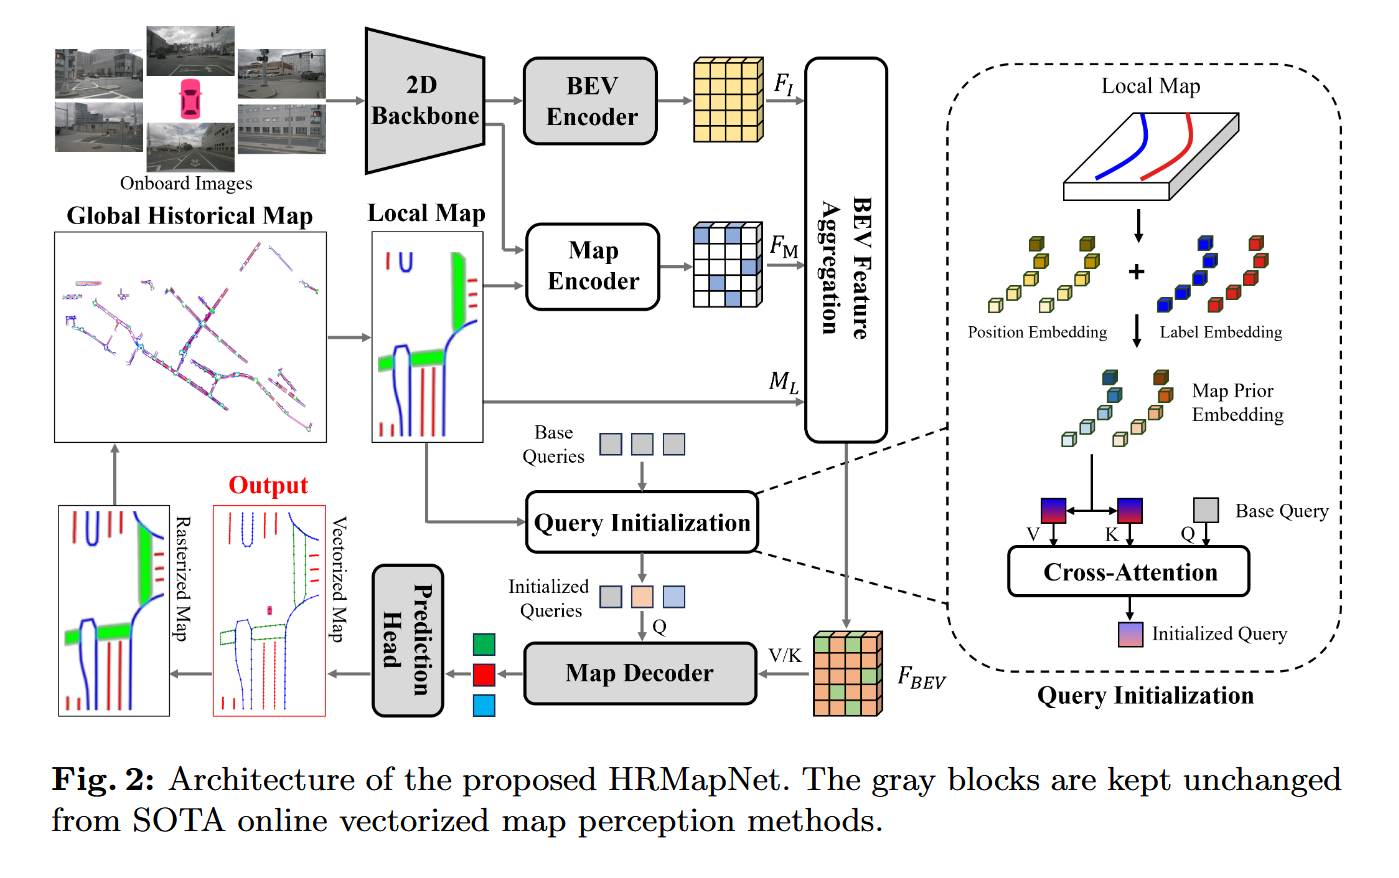

In [ ]:
display(Image('reportFigs/fig2_clean.png'))

The particular instances of this model are in `HRMapNet\projects\configs\hrmapnet\` folder.
I will take the `HRMapNet\projects\configs\hrmapnet\hrmapnet_maptrv2_nusc_r50_110ep.py` model to be specific.

So, as I've already said, HRMapNet is plugged into MapTRv2 


In [ ]:
# lines 80, 81
model = dict(
    type='MapTRv2',
    # ...
)

The `MapTRv2` class is defined in `projects\mmdet3d_plugin\maptr\detectors\maptrv2.py`.

Now, let's approach this beast carefully, step by step.

### Step 1. The Underlying DETR

Let's see what it is based on by stripping away HRMapNet's main novelty, i.e. the use of a historical map as a prior for new outputs:
>In this paper, we want to underscore the crucial role of a historical map...

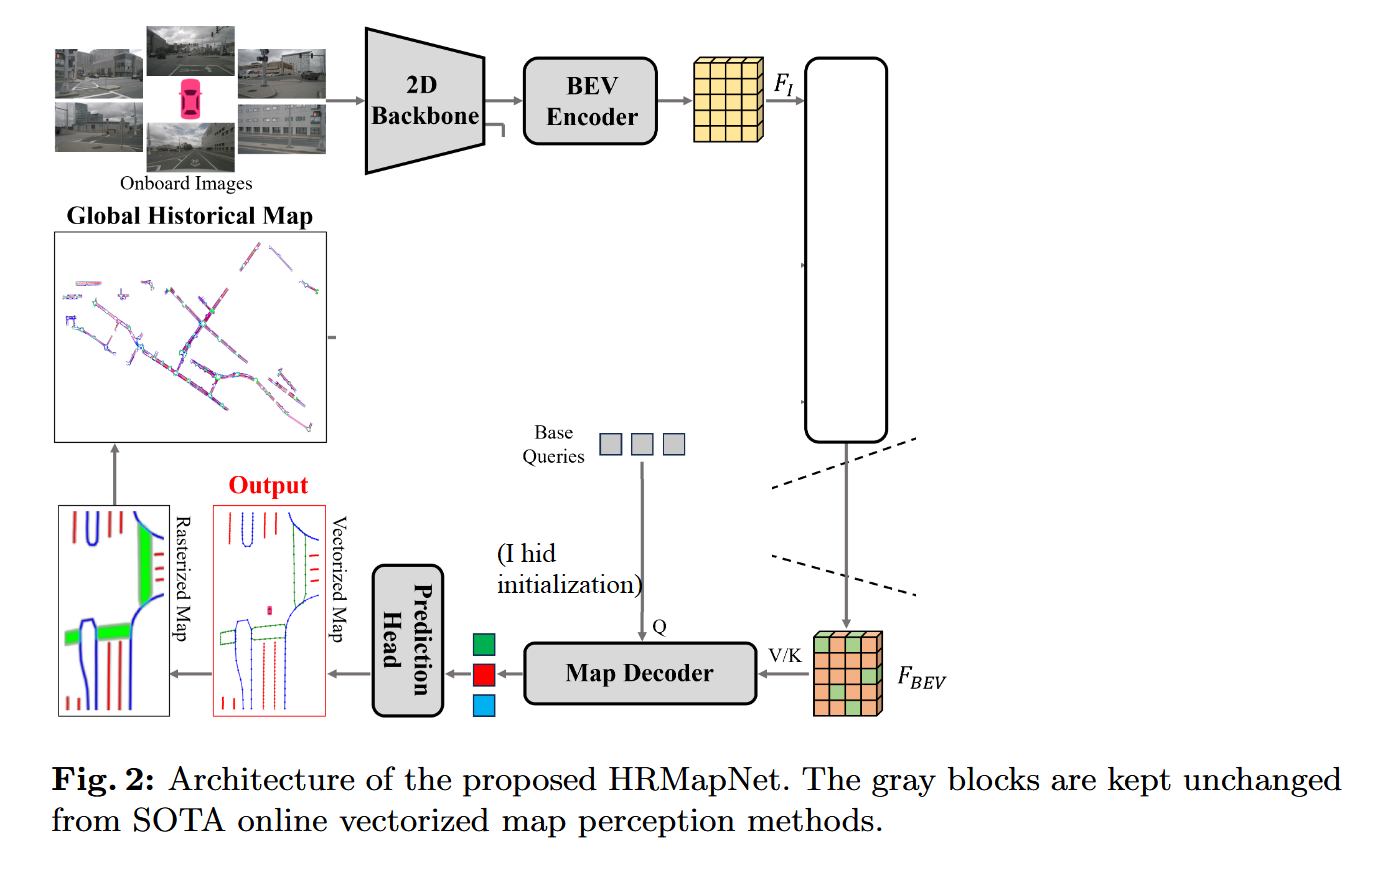

In [ ]:
display(Image('reportFigs/fig2_detr.png'))

Well, what is left is a very simple encoder-decoder architecture, which highly resembles the well-known DETR.

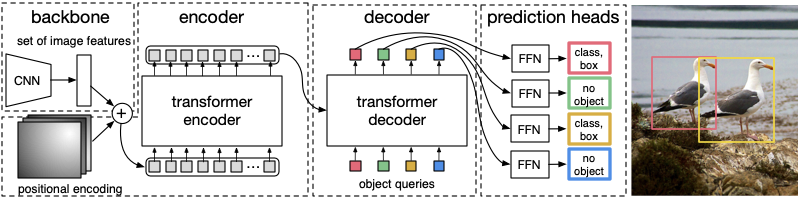

In [ ]:
display(Image("reportFigs/detr.png"))

Let's take a closer look at the gray bubbles to be sure that this is DETR.


#### Backbone 

The purpose of the backbone is to transform raw images into some features.
I've noticed that this part doesn't get too much attention in articles, 
and this leaves an impression that backbone is more of a technicality.
A simple ResNet is used in our case.



In [ ]:
# lines 86, 87
img_backbone=dict(
        type='ResNet',
        # ...
)

It is invoked in the `MapTRv2.extract_img_feat` member function and its mixed precision counterpart `MapTRv2.extract_feat`,
which do not do much else besides invoking (they run some ifs and reshape stuff.)

Note that the backbone does **NOT** fuse images. 
If there is 6 sensors, backbone will output 6 2D-feature maps.
And this is reasonable, as fusing the images basically *IS* the
BEV features extraction. 

##### Why does BEV feature extractor need 2D features as input, not images? 

1. Obviously, to extend the receptive field of a "pixel" to account for context;
1. another benefit of 2D features is that they get rid of the *internal covariate shift* 
on the attn units in query initialization,
that is insignificant details in the picture, which, however, may
influence the distribution of pixels significantly. For example, the car cannot turn as long as another car
is blocking its way, no matter the colour or the shape of that other car. Similarily, the change of season 
(detected by the colour of trees, for example) influences the distribution of images, but not
traffic code. 
As the famous paper on batch norm suggests (sect. 1 of https://arxiv.org/pdf/1502.03167),
eliminating the internal covariate shift speeds up the learning.
That's why we don't put anything too special in the backbone: we need something 
that will produce OK features in reasonable time, thus absorbing the covariate shift.


#### BEV Feature Extraction, Map Decoding and Prediction 

Further work is done by the `pts_bbox_head` parameter, which is an instance of `MapTRv2Head` class (`projects\mmdet3d_plugin\maptr\dense_heads\maptrv2_head.py`.)

In [ ]:
# lines 103-202 of config
pts_bbox_head=dict(
    type='MapTRv2Head',
    # ...
    transformer=dict(
        type='MapTRPerceptionTransformer',
        # ...
        map_encoder=dict( # this param is absent in the original MapTR 
                            # as the name implies, it is the Map Encoder,
                            # suggested by the HRMapNet authors. Thus, not relevant
                            # for now. Just note that it is here, too
            type='BEVFormerEncoder', # ...
        ),
        encoder=dict(
            type='LSSTransform',
            # ...
        decoder=dict(
            type='MapTRDecoder', # ...
            )
        ),
    ),
    positional_encoding=dict(
        type='LearnedPositionalEncoding', # ...
    ),
    # ...
)



The name `pts_bbox_head` is not clear, 
since, the MapTR article gave me an impression they are trying to avoid bounding boxes (sect. 1 of https://arxiv.org/pdf/2208.14437):
 > Different from object detection in which objects can be easily geometrically abstracted as bounding
box, vectorized map elements have more dynamic shapes. 

I suppose, they actually mean that the "big polygonal" bbox is obtained from small regular ones. Actually, this seems reasonable and I do not see any alternatives.

##### BEV features extraction

BEV features are extracted by the `pts_bbox_head.transformer` member (this is a member of the base `DETRHead` class),
an instance of `MapTRPerceptionTransformer` class (`projects\mmdet3d_plugin\maptr\modules\transformer.py`),
in its member function `pts_bbox_head.transformer.get_bev_features`,
which calls an appropriate encoder, an LSS Transformer in our case (specified in `pts_bbox_head.transformer.encoder`).
The original paper on HRMapNet does not justify this choice anyhow, and it is not consistent:
some other configurations use other encoders.
MapTR paper simply mentions that 
it is compatible with LSS and runs some tests with it 
(sect. 4.2 in https://arxiv.org/pdf/2208.14437).

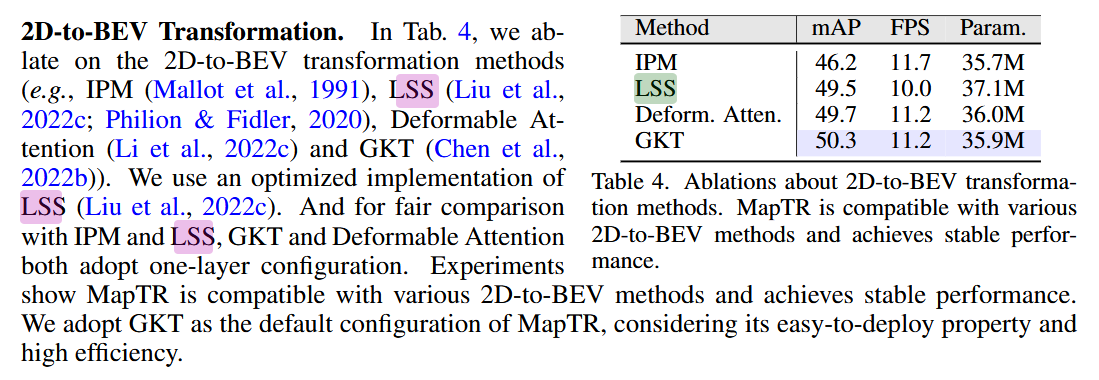

In [ ]:
display(Image("reportFigs/lss_tests.png"))

Basically, this is just another transformer layer. 
What is the difference between these two consequent transformer layers? 
I suppose, the reason is the fusion, not shown in the diagram for HRMapNet. 
For example, look at the BEVFormer architecture (fig. 2 in https://arxiv.org/pdf/2203.17270)

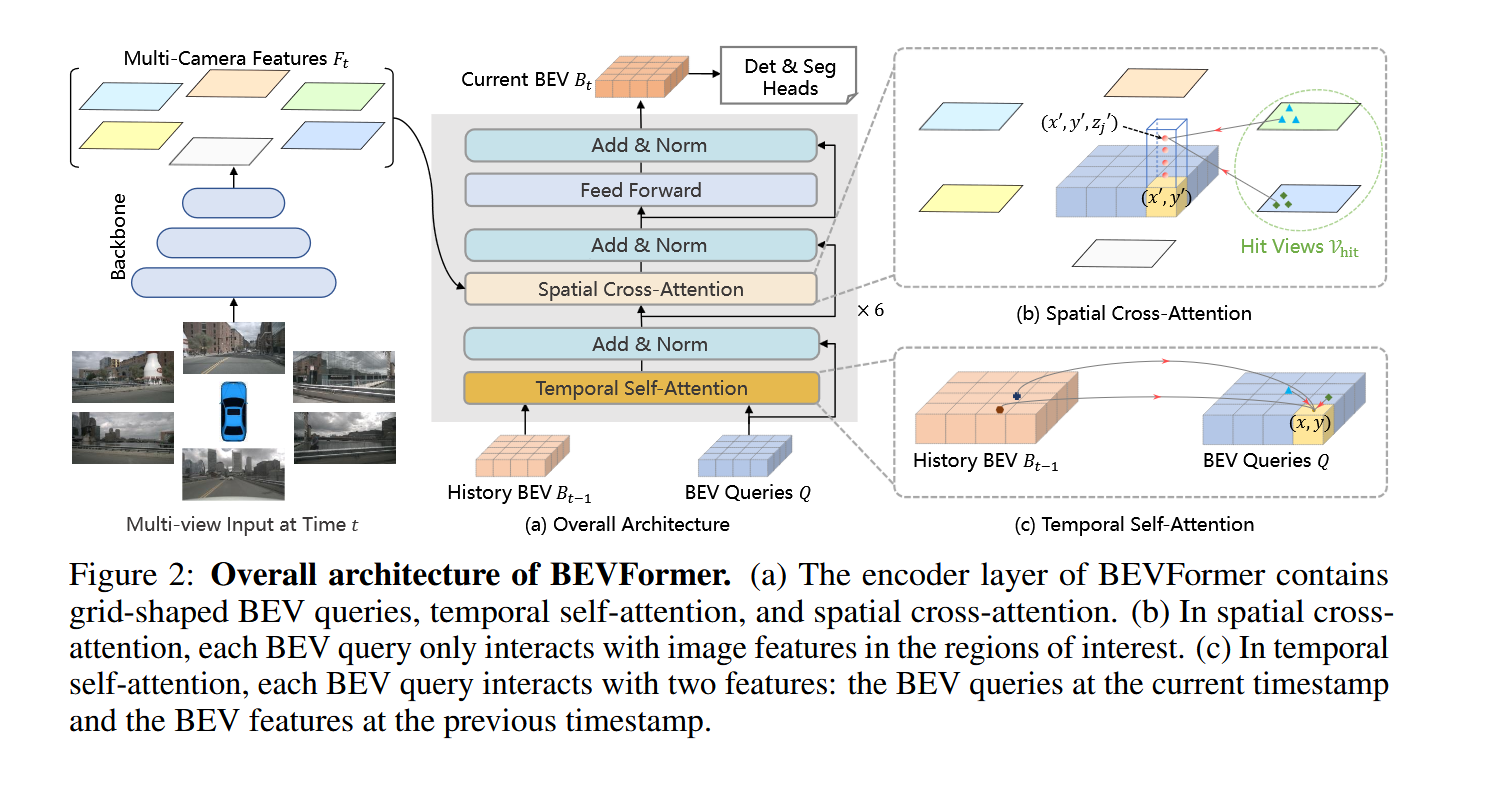

In [ ]:
display(Image('reportFigs/bevformer.png'))

Sensors output several images (usually, 6), and the backbone extracts features separately from each.
The 2D-to-BEV layer, however, fuses the features of these 6 images into one map of features, which we call BEV features.


##### Map Decoder and the Prediction Head

BEV features are then decoded with `pts_bbox_head.transformer.decoder` member,
an instance of `MapTRDecoder` class 
(`projects\mmdet3d_plugin\maptr\modules\decoder.py`).

In [ ]:
 # lines 166-202 of config
decoder=dict(
    type='MapTRDecoder',
    num_layers=6,
    # ...
    transformerlayers=dict(
        type='DecoupledDetrTransformerDecoderLayer',
        # ...
        attn_cfgs=[
            dict(
                type='MultiheadAttention',
                # ...
            ),
            dict(
                type='MultiheadAttention',
                # ...
            ),
            dict(
                type='CustomMSDeformableAttention',
                # ...
            ),
        ],
        # ...
        operation_order=('self_attn', 'norm', 'self_attn', 'norm', 'cross_attn', 'norm',
                            'ffn', 'norm')
    )
)

The decoder simply applies the `DecoupledDetrTransformerDecoderLayer` 6 times (given by `num_layers`; see https://github.com/open-mmlab/mmcv/blob/f19d3e771c211ca20e3f8ab838e3851cae263035/mmcv/cnn/bricks/transformer.py#L889).
The result is passed the prediction head, which is just 2 
(default from https://github.com/open-mmlab/mmdetection/blob/main/mmdet/models/dense_heads/detr_head.py)
fully-connected layers, just like in the original DETR architecture (caption to fig. 2 in https://arxiv.org/pdf/2005.12872)
> We pass each output embedding of the
decoder to a shared feed forward network (FFN) that predicts either a detection (class
and bounding box) or a “no object” class.

(The most interesting part of map decoding are the queries passed to the transformer. 
However, I will speak of them later,
together with query initialization,
since the two are coupled significantly.)

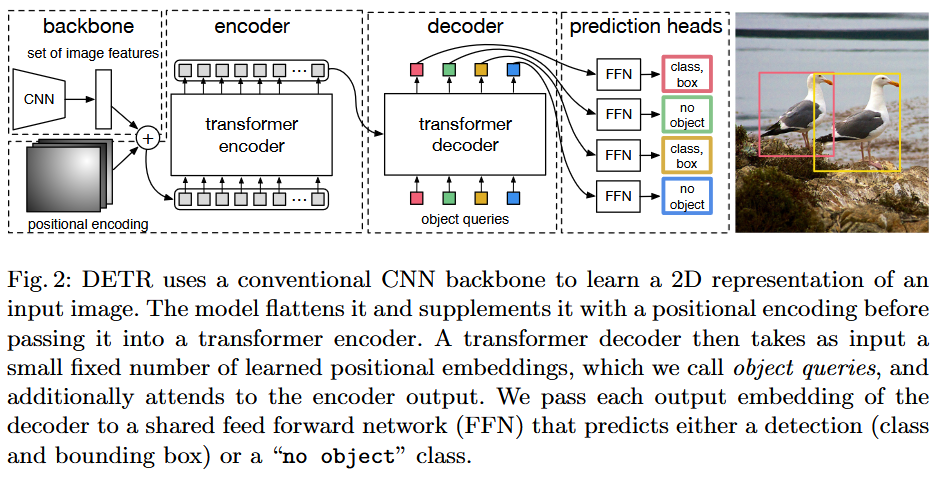

In [ ]:
display(Image("reportFigs/detr_w_caption.png"))

`pts_bbox_head.transformer` returns the results of the prediction head.
These are not bboxes yet, first they should pass through the `pts_bbox_head.bbox_coder`, 
an instance of `MapTRNMSFreeCoder` class (`projects\mmdet3d_plugin\core\bbox\coders\nms_free_coder.py`).
I didn't find any interesting work done there, mostly it's just denormalizing and rescaling and so on.

In [ ]:
# lines 391-406 of projects\mmdet3d_plugin\maptr\detectors\maptrv2.py
def simple_test_pts(self, x, lidar_feat, img_metas, local_map=None, rescale=False):
    """Test function"""
    outs = self.pts_bbox_head(x, lidar_feat, img_metas, local_map=local_map)

    bbox_list = self.pts_bbox_head.get_bboxes(
        outs, img_metas, rescale=rescale)
    
    bbox_results = [
        self.pred2result(bboxes, scores, labels, pts)
        for bboxes, scores, labels, pts in bbox_list
    ]

    if self.global_map is not None and self.update_map:
        new_map = self.pts_bbox_head.get_pred_mask(outs) # Generate bboxes from bbox head predictions.
        self.update_global_map(img_metas, new_map, 'val')
    return outs['bev_embed'], bbox_results

So, the bbox prediction indeed follows the DETR paradigm, which concludes this step.
In the next step we will see how these bboxes are used.

### Step 2. Using Local Map as a Prior

#### Query Initialization

##### Base queries

MapTR paper introduces 3 types of queries: instance-level, point-level and hierarchial.
They use instance-level queries to predict the label of a detected object,
and the point-level queries to predict the shape of a given object. 
Each object in a vector map is given by $N_v$ points 
(where $N_v$ is a constant, big enough to properly encode any reasonable shape in a **local** map),
so a prediction of a *single* object is *one* label and $N_v$ points

Thus, for each object $i$ we need 
one query $q^{ins}_i$ to detect its label
and $N_v$ queries $q^{hie}_{ij}$ to detect its shape, 
where the latter are obtained from the "shared" point queries 
$q^{pt}_j, j=0,..., N_v-1$ by simple sum
$$ q^{hie}_{ij} = q^{ins}_i + q^{pt}_j $$

I suppose, the sum is chosen here just as a simplest way to combine
two vectors.
Concatenating them is possible, too,
as we will see later 
(HRMapNet added concatenation, instead of summing, as an option).

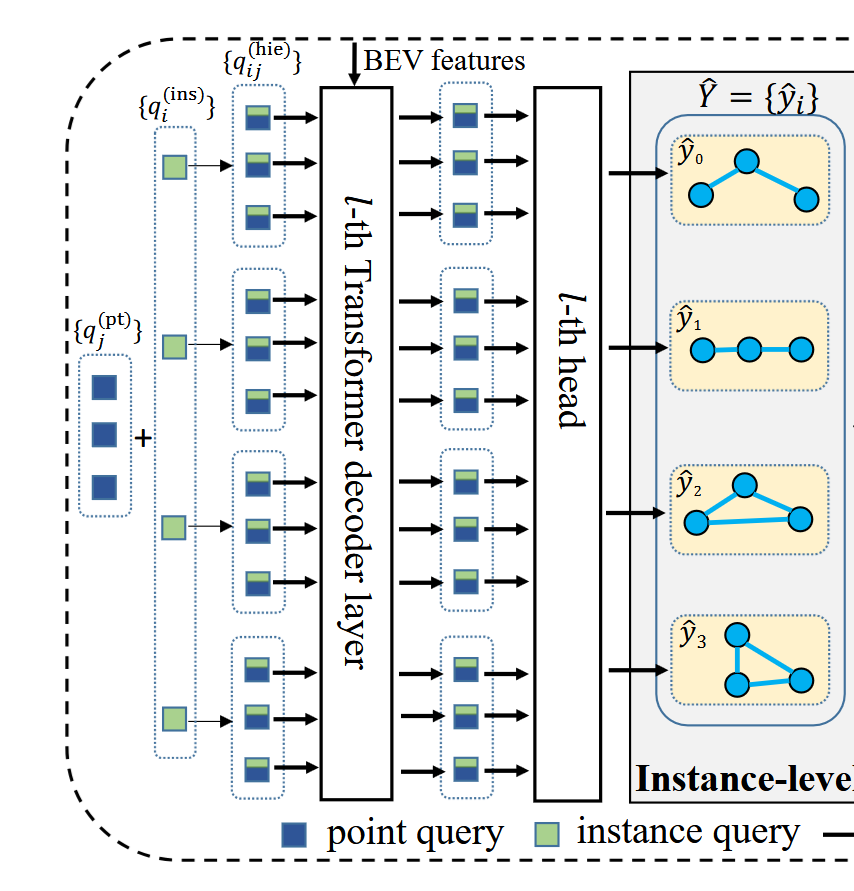

In [ ]:
# fig. 4 in https://arxiv.org/pdf/2208.14437
display(Image("reportFigs/maptr_queries.png"))

Here is the code for base query creation from "vanilla MapTR"

In [ ]:
# https://github.com/hustvl/MapTR/blob/main/projects/mmdet3d_plugin/maptr/dense_heads/maptr_head.py

# lines 139-188
def _init_layers(self): # called at the end of __init__
    """Initialize classification branch and regression branch of head."""
    # ...
    if not self.as_two_stage: # simply checks if the decoder will run at all
        # ...
        if self.query_embed_type == 'all_pts':
            self.query_embedding = nn.Embedding(self.num_query,
                                                self.embed_dims * 2)
        elif self.query_embed_type == 'instance_pts':
                self.query_embedding = None
                self.instance_embedding = nn.Embedding(self.num_vec, self.embed_dims * 2)
                self.pts_embedding = nn.Embedding(self.num_pts_per_vec, self.embed_dims * 2)

# lines 203-228
def forward(self, 
            #...
):
        # ...
        if self.query_embed_type == 'all_pts':
            object_query_embeds = self.query_embedding.weight.to(dtype)
        elif self.query_embed_type == 'instance_pts':
            pts_embeds = self.pts_embedding.weight.unsqueeze(0)
            instance_embeds = self.instance_embedding.weight.unsqueeze(1)
            # below are the hierarchial embeddings
            object_query_embeds = (pts_embeds + instance_embeds).flatten(0, 1).to(dtype) 
            # the pair-wise summation is done by the unsqueezing trick, see below
        # ...


In [2]:
a = torch.randn(size=(1,4,5))
b = torch.randn(size=(3,1,5))
(a+b).shape

torch.Size([3, 4, 5])

As you can see, it is very simple.
HRMapNet authors coupled it with query initialization, 
adding code right into this place.
So, in the next step we will see how these lines changed.

##### Initialization 

Already we see the similarity with HRMapNet's initialization: given a local map,
the query initialization unit produces "point-level" and "instance-level",
i.e. position and label, embeddings.
Then, their sum - the, "hierarchial" or map prior, embedding, - is used to initialize 
the base hierarchial queries.

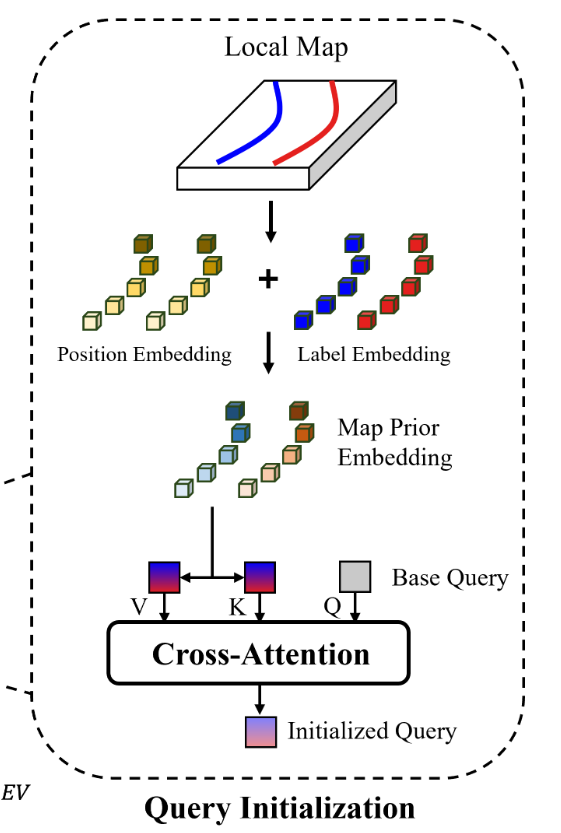

In [ ]:
# fig. 2 in https://arxiv.org/pdf/2409.00620
display(Image("reportFigs/query_init.png"))

Although it is not explicitly said in this paper, after the considerations above it must be
obvious that queries $Q$, that are initialized, are the hierarchial queries from the MapTR paper.

The code, on the other hand, is very self-explanatory, given you have seen the MapTR original.

In [ ]:
# projects\mmdet3d_plugin\maptr\dense_heads\maptrv2_head.py
# lines 202-303
def _init_layers(self): # called at the end of __init__
        """Initialize classification branch and regression branch of head."""
        # ...
        if self.query_embed_type == 'map_pts':
            self.instance_embedding = nn.Embedding(self.num_vec, self.embed_dims)
            self.pts_embedding = nn.Embedding(self.num_pts_per_vec, self.embed_dims)
            self.label_encoder = nn.Linear(3, self.embed_dims)
            self.query_attention = MultiheadAttention(self.embed_dims,
                                                        num_heads=8,
                                                        batch_first=True,
                                                        dropout=0.0)
        # ...

# lines 363-392
def forward(self, # ...
             local_map=None,):
        # ...
        if self.query_embed_type == 'map_pts':
            # define uninitialized base queries
            pts_embeds = self.pts_embedding.weight.unsqueeze(0)
            instance_embeds = self.instance_embedding.weight[0:num_vec].unsqueeze(1)
            query = (pts_embeds + instance_embeds).flatten(0, 1).to(dtype)

            # downsample local map and whatnot
            local_map_input = local_map.permute(1, 0, 2).view(bs, self.bev_h, self.bev_w, -1).permute(0, 3, 1, 2)
            local_map_input = F.interpolate(local_map_input,
                                            [self.bev_h // self.map_query_scale,
                                             self.bev_w // self.map_query_scale]).permute(0, 2, 3, 1)
            local_map_pos = F.interpolate(bev_pos,
                                          [self.bev_h // self.map_query_scale,
                                           self.bev_w // self.map_query_scale]).permute(0, 2, 3, 1)
            local_map_valid, _ = torch.max(local_map_input, dim=-1)

            # initialize
            query_embeds_list = []
            for i in range(bs): # bs = batch size
                # find non empty positions, see p. 7 of https://arxiv.org/pdf/2409.00620
                # "a valid location where map elements exist" --- p.
                valid_index = local_map_valid[i] > 0.8 

                if torch.equal(valid_index,
                               torch.zeros(valid_index.shape, dtype=torch.bool, device=valid_index.device)):
                    # do noting if the local map is empty (or very sparse)
                    # I suppose, for performance reasons,
                    # not to run attention in vanity
                    query_embeds_list.append(query.clone())
                else:
                    # retrieve priors
                    map_pos_embed = local_map_pos[i][valid_index]
                    map_label = local_map_input[i][valid_index]
                    map_label_embed = self.label_encoder(map_label)
                    map_query = map_pos_embed + map_label_embed

                    # and run attention
                    # query is the "hierarchial query", as expected
                    query_embeds = self.query_attention(query.unsqueeze(0), key=map_query.unsqueeze(0))
                    query_embeds_list.append(query_embeds.squeeze(0))
            object_query_embeds = torch.stack(query_embeds_list, dim=0)
        # ...

I left only the `map_pts` branches, as this is the `query_embed_type` specified in the configuration I chose. 
Moreover, all the other configs that build upon MapTRv2 choose the same.

I suppose, this options yields exactly the formulas used in the paper.
For contrast, setting  `query_embed_type=map_instance_pos` 
replaces the sum with concatenation in the formula for hierarchial query,
which is, as I've mentioned above, another reasonable option, which was 
worth adding (the general schemes seems different as well, for some reason.)

Let's not stop on these technicalities for too long.

##### So, what is the purpose of this?

>  Within a DETR [4] paradigm, a set of learnable queries will
interact with extracted features to search for desirable elements. Without prior
information, queries would search from random and prediction results are refined
gradually through several decoder layers. (sect. 3.4 in https://arxiv.org/pdf/2409.00620)

>  These input embeddings are learnt positional encodings that we refer to as object queries,
and similarly to the encoder, we add them to the input of each attention layer. 
(sect. 3.2 in https://arxiv.org/pdf/2005.12872) 

I suppose, the base embeddings are able to learn some very basic features, like:
1. the expected number of a a given label.
For example, an expected number of other cars on the road (might exceed 10, since the field of view is $360^\circ$)
is greater than an expected number of pedestrian crossings (I wouldn't expect to see more than 4.)
Thus, the instance-level embeddings would learn to contain more "expecting car" queries,
rather than "expecting a pedestrian crossing" queries;
2. the usual position of objects. For example, there are more objects to detect on the ground rather than in the sky. So, the position embedding will learn to have more closer to the ground positions;
3. Adding an instance-level and a point-level query,
we get something of the form "is there a car ahead?" or
"is there a pedestrian crossing to the right?" or "is there nothing behind you"? 
Eventually, softmax assigns probabilities that the answers to those question is "yes",
and thus a prediction is made.

However, all of this is very shaky. On a highway there are no pedestrian crossings,
but there are a lot of cars 
*(the latter does not follow from the local map directly that 
would unlikely store temporary information, but still; however, a more advanced 
version of this net might start keeping track of type of the road and etc.)*,
thus maintaing queries that expect crossings is just a waste.
Query initialization attempts to fix this waste and adjust the "mean queries" to 
queries more adequate to the current position.


##### The use of queries in prediction

The queries are then passed to a deformable attn unit to interact with BEV features.

Deformable attn is simply a variation of classic attn 
that does not compare each query to each key (which is very slow);
instead, given a query, it estimates the center of the resulting bbox
(called a *reference point*),
samples several points around it
and compares the query to keys in those sampled points only. 


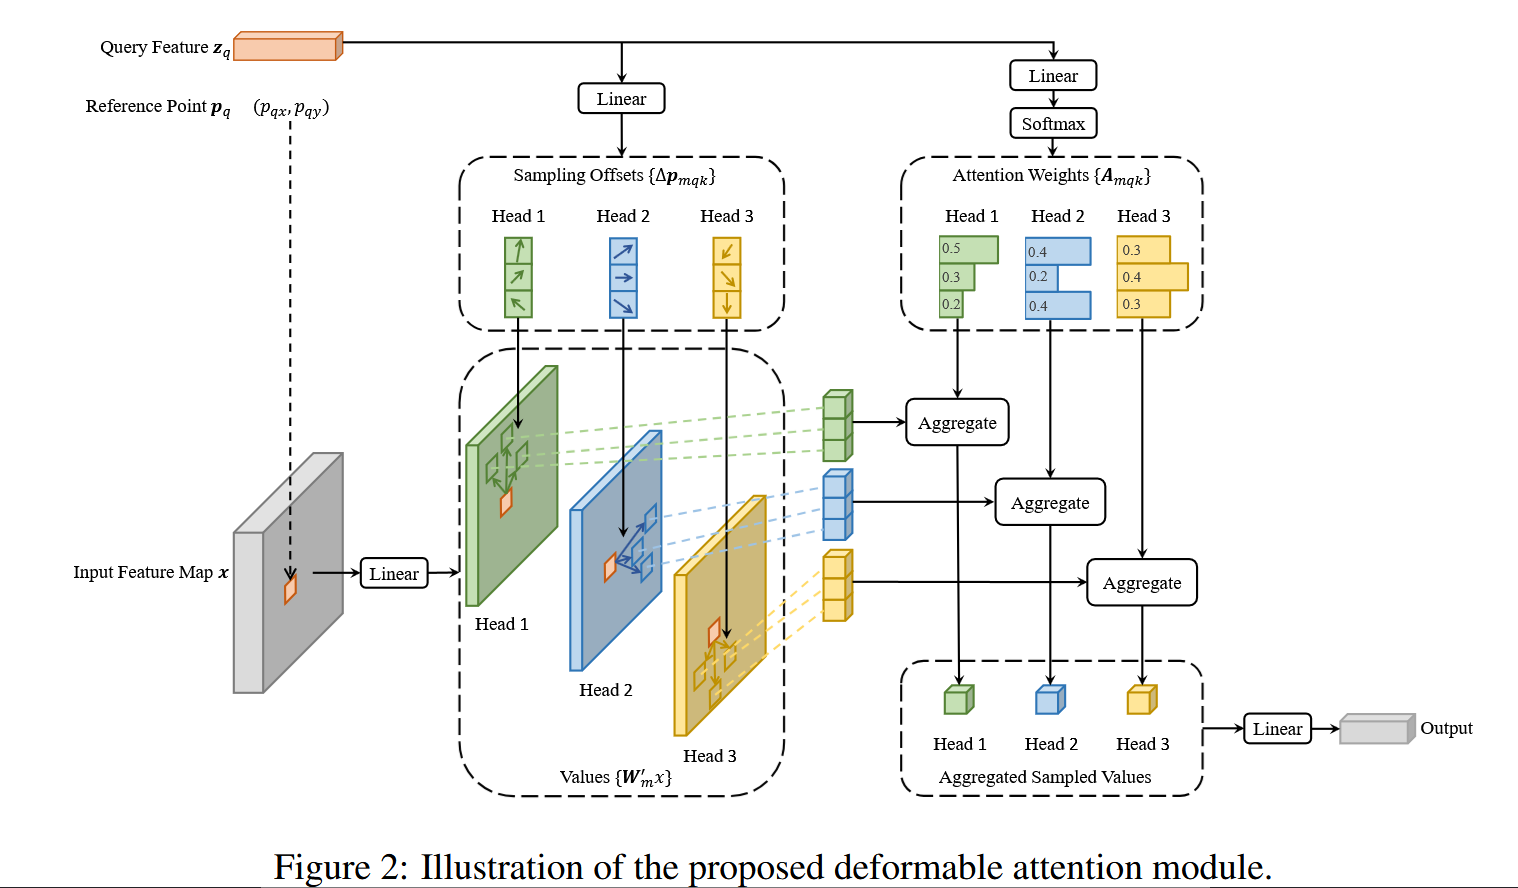

In [ ]:
# fig. 2 in https://arxiv.org/pdf/2010.04159
display(Image("reportFigs/defattn.png"))

In [ ]:
# projects\mmdet3d_plugin\maptr\modules\transformer.py
# lines 472-488
if self.query_pos_embedding == 'map_pts' or self.query_pos_embedding == 'map_instance':
    query = object_query_embed
    reference_points = self.reference_points(query).sigmoid()
    init_reference_out = reference_points
    query_pos = None
# ...
elif self.query_pos_embedding == 'map_instance_pos':
    query_pos, query = torch.split(object_query_embed, self.embed_dims, dim=-1)
    reference_points = self.reference_points(query_pos).sigmoid()
    init_reference_out = reference_points
    query_pos = None

The estimation is most illustrative for the `map_instance_pos` case:
 the embedding is split back into position and label embedding, and only the former is used to predict
 the reference point.

 The predictor itself is a very simple regression branch:

In [ ]:
# projects\mmdet3d_plugin\maptr\modules\transformer.py
# lines 107-120
if self.query_pos_embedding == 'instance' or self.query_pos_embedding == 'map_instance_pos':
    self.reference_points = nn.Sequential(
        nn.Linear(self.embed_dims, self.embed_dims),
        nn.ReLU(),
        nn.Linear(self.embed_dims, self.num_pts_per_vec * 2),
    )
elif self.query_pos_embedding == 'map_pts':
    self.reference_points = nn.Sequential(
        nn.Linear(self.embed_dims, self.embed_dims),
        nn.ReLU(),
        nn.Linear(self.embed_dims, self.embed_dims),
        nn.ReLU(),
        nn.Linear(self.embed_dims, 2),
    ) # see sidenote

###### sidenote

The difference in output dimensions of `self.reference_points` catches the eye. For `map_pts` mode 
(the closest one to the paper)
it is 2, so for a single query a single reference point is predicted.
For `map_instance_pos` a whole set of reference points is predicted. 

This is looks like a technicality, in fact. If you take a look at **base** query generation
in `map_instance_pos` mode, you will see that the point-level queries are not generated 
right away. I guess, they are generated here instead
(lines 417-420 in `projects\mmdet3d_plugin\maptr\dense_heads\maptrv2_head.py`.)
After such a weird replacement, we end up with the same amount of reference points per object.
I guess, this is a replacement for "vectorized" concatenation. Anyway, this isn't important.

#### Map Encoding



The map encoding unit takes a local map and 2D features 
(and, perhaps, previous BEV features)
and produces "additional map features", using
spatial (and temporal, if previous BEV features are given) cross-attn.



Spatial attn is used a bit differently here.
 Firstly, reference points lose their "bbox centre estimation" semantic;
also, some technicalities are needed to use spatial attn in 3D 
(before we used the "vanilla" Deformable Attn, which works in 2D; which is reasonable from
BEV --- bird's-eye view.)

Temporal attn is
a deformable attention unit, too, which helps us "re-detect" objects
that were already registered by the cameras but in a *slightly* different place
(because the car is moving.) 
The use of reference points and sampled offsets arises here naturally.

All of this was introduced with BEVFormer. In fact, it is precisely the encoder that is used here.

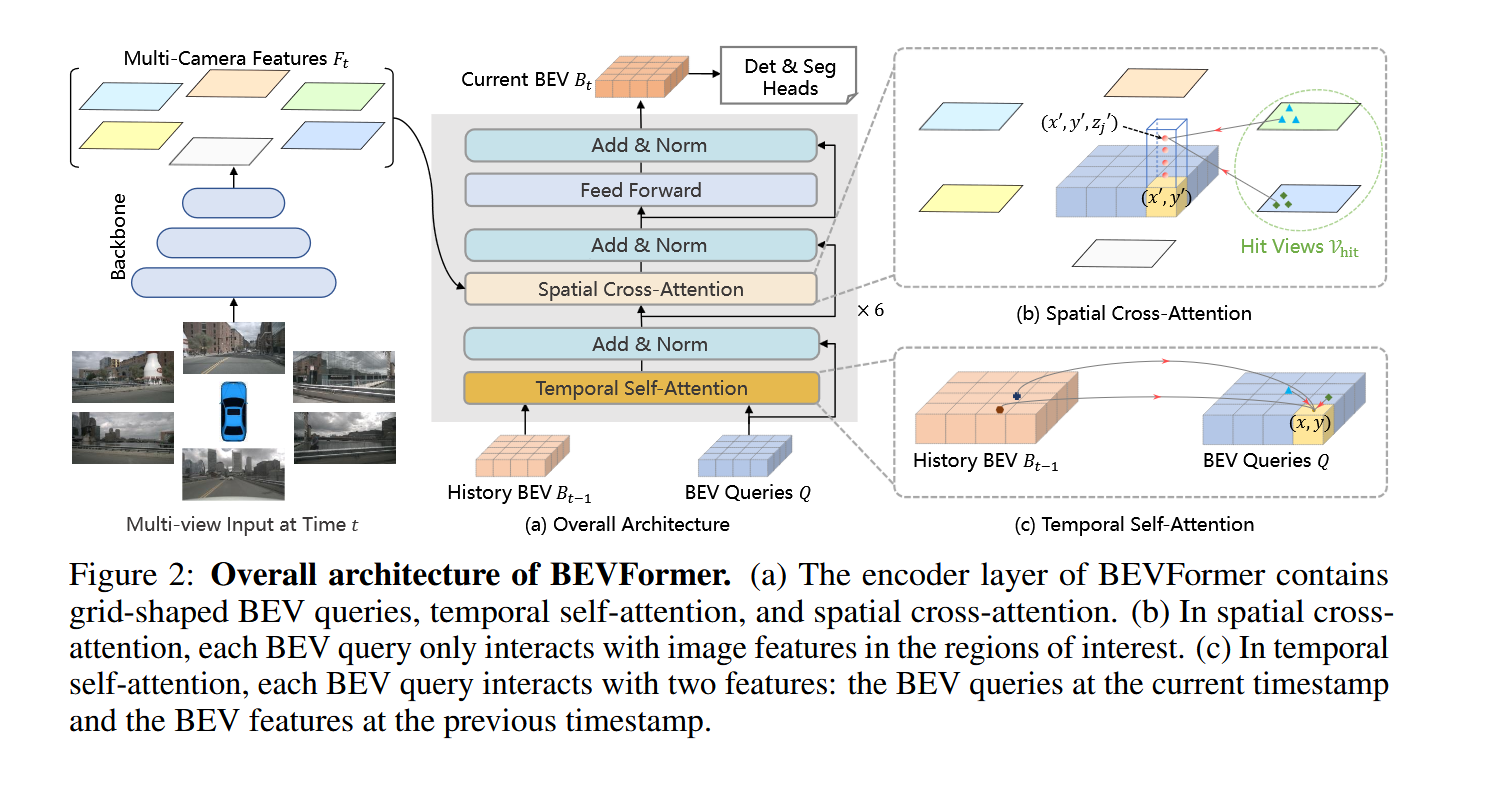

In [4]:
display(Image("reportFigs/bevformer.png"))

#### Feature Aggregation

This unit is just a single convolution layer:
$$ F_{BEV} = Conv(Concat(F_I + F_M), M^l) $$
> Here, $F_M$ is added to $F_I$ to compensate for deficiencies. (sect. 3.3 of https://arxiv.org/pdf/2409.00620)

To be honest, I have no clue what deficiencies they are compensating for.
To me, this looks like a usual convolution layer, nothing more.


### Step 3. Global Map

Unlike the above, the global map part looks rather dull to me,
as it is mostly technical details about maintaining a map.
Since the text is very long already, I will just say that the
`GlobalMap` class is implemented in `projects\mmdet3d_plugin\hrmap\global_map.py`. 

### Finally, 
let's get the sizes of the tensors out of the way.
The dimensions are listed right at the top of the configuration file. Here they are 

In [ ]:
# lines 48-56
_dim_ = 256
_pos_dim_ = _dim_ // 2
_ffn_dim_ = _dim_ * 2
_num_levels_ = 1
bev_h_ = 200
bev_w_ = 100
queue_length = 1  # each sequence contains `queue_length` frames.

## 3. Train

According to https://github.com/HXMap/HRMapNet/blob/master/docs/train_eval.md,
training is done simply by running a script.

```bash
./tools/dist_train.sh ./projects/configs/hrmapnet/hrmapnet_maptrv2_nusc_r50_24ep.py 8
```

It looks like this:
```bash

#!/usr/bin/env bash

CONFIG=$1
GPUS=$2
PORT=${PORT:-28509}

PYTHONPATH="$(dirname $0)/..":$PYTHONPATH \
python3 -m torch.distributed.launch --nproc_per_node=$GPUS --master_port=$PORT \
    $(dirname "$0")/train.py $CONFIG --launcher pytorch ${@:3} --deterministic

```

The interpreter accepts kwargs.
The full list of kwargs it can parse is given in `train.py`, in function `parse_args`.


In [ ]:
# tools\train.py
# lines 33-38
def parse_args():
    parser = argparse.ArgumentParser(description='Train a detector')
    parser.add_argument('config', help='train config file path')
    parser.add_argument('--work-dir', help='the dir to save logs and models')
    parser.add_argument(
        '--resume-from', help='the checkpoint file to resume from')
    # ...

As you can see, it accepts a checkpoint to `--resume-from`.
Thus, additional training is done just as easily by a quick change to the `dist_train.sh` script.

`grep -r` did not reveal `wandb` support.

## 4. Visualize

Although I didn't manage to install the HRMapNet (yet),
I tried https://rerun.io/ examples.

## 5. Improve!

### Other Sensors

1. Firstly, it is common to install not just cameras on self-driving cars, but also lidars and
other types of sensors.
The architecture itself allows new types of sensors gladly:

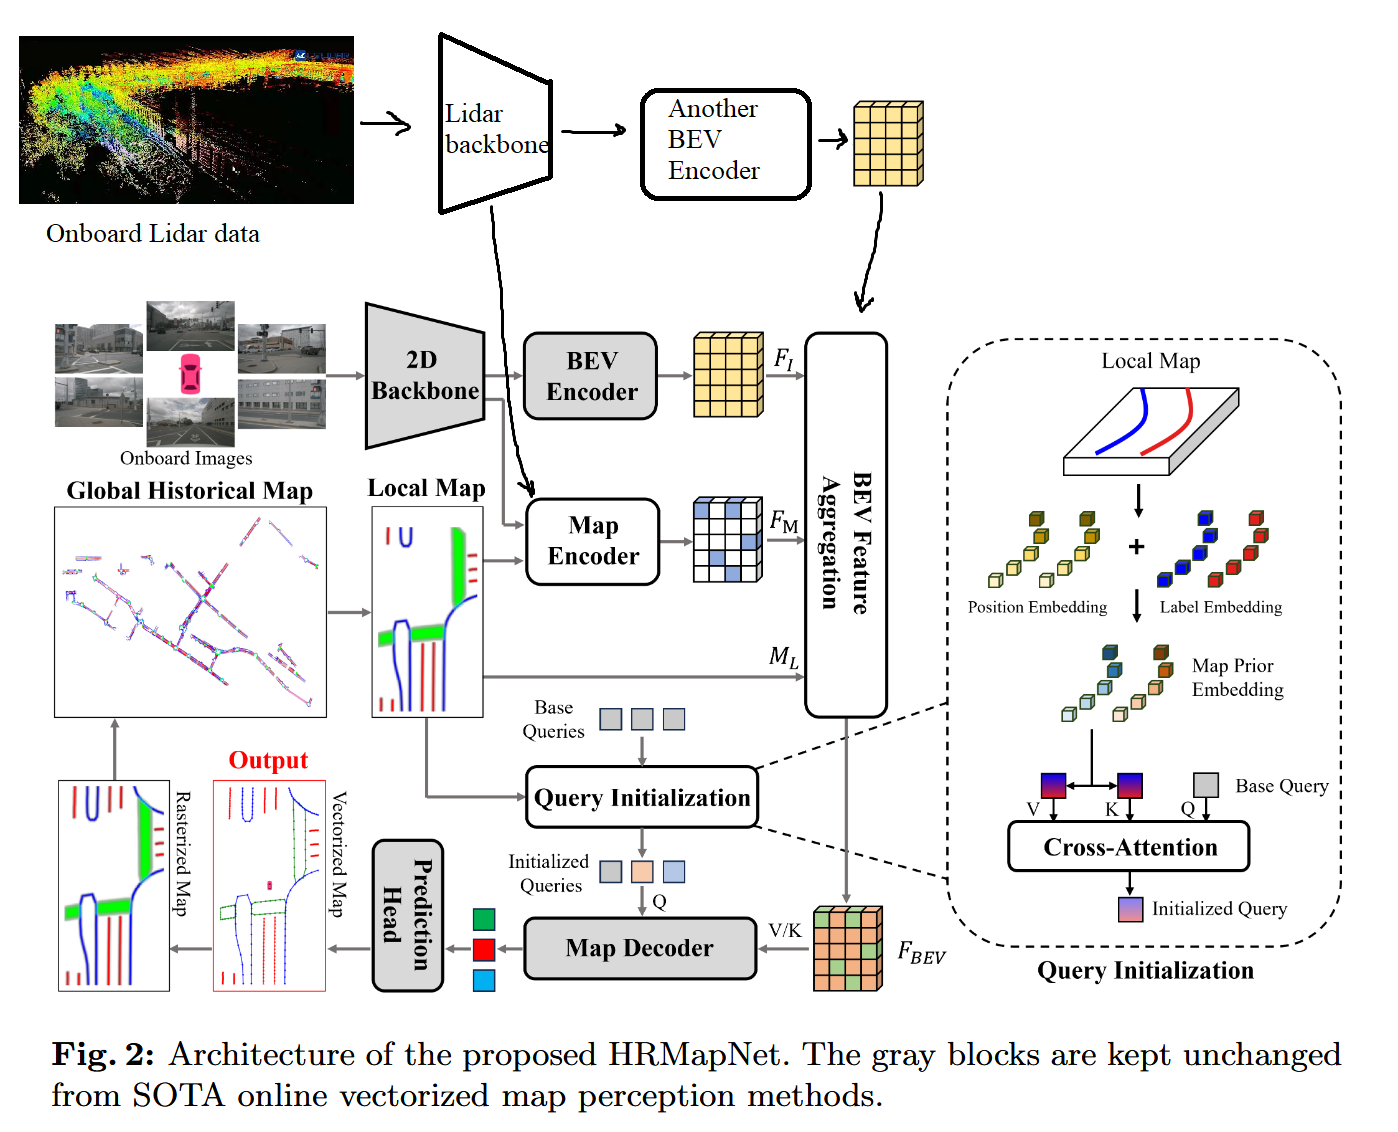

In [6]:
display(Image("reportFigs/other_sensors.png"))

Actually, lidars seem to be supported already (the code I read suggests so!)

### Highway vs. Country road

As I noticed above, in the query initialization chapter,
it might be useful to know what type of road we are currently on.
For example, it is pointless to look for pedestrian crossings on a highway.
Thus, we can make better use of available queries once we know where we are.

This improvement might also contribute to the safety. For example, if we 
instruct the detector to look for more people in proximity
of schools and kindergartens (once the 5th lesson ends, a lot of children
simultaneously exit the school,
sometimes not following the road safety principles;
a self-driving car should account for such things very carefully.)

This can be added to the current map very easily: each "roadbed" pixel starts carrying an embedded road type.

Unfortunately, it might be expensive in memory. Perhaps, we put the memory we reserved to a better use.
I don't think that road type can be retrieved from historical BEV features.

As a matter of fact, road type should **not** be necesserily precomputed,
since road signs can hint at it. For example, there is a children warning sign;
also, if the current speed limit is 90+ km/h, we are probably on a highway; 
and so on...

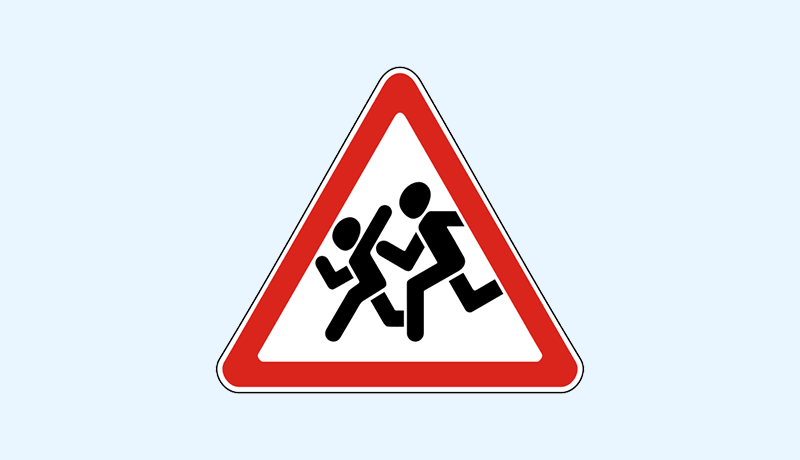

In [5]:
display(Image("reportFigs/ostorozhno-deti.png"))